## 1、导入相关依赖

In [1]:
# 禁用警告显示（避免无关输出干扰）
import warnings
from typing import cast  # 类型注解工具

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint  # 用于随机参数搜索
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit  # 时间序列专用交叉验证
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# MAPIE相关导入
from mapie._typing import NDArray
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)  # 覆盖率和区间宽度评估
from mapie.regression import MapieTimeSeriesRegressor  # 时序预测区间核心类
from mapie.subsample import BlockBootstrap  # 保持时序结构的重采样方法

warnings.simplefilter("ignore")  # 全局忽略警告
from matplotlib import rcParams
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from etide.feature_engineer import  FeatureGenerator
import itertools
from util import  plot_prediction_intervals , evaluate_intervals , evaluate_intervals_df,evaluate_compare_df,compare_different_quantile_model,plot_grouped_scatter
# 在训练前设置随机种子
import random
import os
# 设置随机种子
SEED = 42
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 读取电价价格相关的供需等数据

In [2]:
# 山东数据，从csv文件读取
df = pd.read_csv("shandong_data_20240801-20250417.csv",index_col=0, parse_dates=True)
print(df.index.dtype)  # 应输出datetime64[ns]
print(df.shape)  # 输出数据集的形状

datetime64[ns]
(24960, 17)


## 特征工程

In [3]:
# 调用FeatureGenerator类进行特征工程
fg = FeatureGenerator()
FEATURE_FUNCTIONS = [
                     'hour',
                     'intraday_mean',
                     'intraday_max',
                     'intraday_min',
                     'diff_1',
                     'diff_2',
                     'rolling_mean_4',
                     'rolling_mean_8',
                     'rolling_mean_16',
                     ]
df = fg.generate_features(df, feature_functions=FEATURE_FUNCTIONS, cols=['竞价空间'])

# ================= 特征筛选 =================
# 移除临时列和原始列（保留特征）
all_zero_cols = df.columns[(df == 0).all()]  # 所有值均为 0 的列
# 排除非特征列
columns_to_exclude = ['日前电价'] + list(all_zero_cols) + ['模型1', '模型2', '模型3', '模型4','4个模型融合','线上日前电价预测']
features = df.columns.difference(columns_to_exclude)
# 处理缺失值（由于滞后特征产生的NaN）
df = df.loc[~np.any(df[features].isnull(), axis=1)]  # 删除含NaN的行
print(f"数据集大小: {df.shape}")
print(f"生成特征总数: {len(features)}")
print("示例特征：", list(features))



数据集大小: (24960, 26)
生成特征总数: 18
示例特征： ['hour', '光伏', '地方电厂发电总加', '抽蓄', '新能源', '竞价空间', '竞价空间_diff_1', '竞价空间_diff_2', '竞价空间_intraday_max', '竞价空间_intraday_mean', '竞价空间_intraday_min', '竞价空间_rolling_mean_16', '竞价空间_rolling_mean_4', '竞价空间_rolling_mean_8', '系统负荷', '联络线', '自备机组总加', '风电']


## 方法二、分位数梯度提升树

### 1、训练集、测试集划分

In [4]:
# 划分训练集、验证集和测试集的函数，输入参数为数据集df和划分比例
def split_data(df, train_ratio=0.7, val_ratio=0.2):
    """
    划分数据集为训练集、验证集和测试集
    :param df: 输入数据集
    :param train_ratio: 训练集比例
    :param val_ratio: 验证集比例
    :return: 训练集、验证集和测试集
    """
    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * val_ratio)
    test_size = len(df) - train_size - val_size

    train_data = df[:train_size]
    val_data = df[train_size:train_size + val_size]
    test_data = df[train_size + val_size:]
    return train_data, val_data, test_data
# 划分数据集
train_data, val_data, test_data = split_data(df,train_ratio=0.8, val_ratio=0.0)
print(f"训练集大小: {train_data.shape}")
print(f"验证集大小: {val_data.shape}")
print(f"测试集大小: {test_data.shape}")

# 训练集、验证集和测试集的特征和标签
X_train = train_data[features]
y_train = train_data['日前电价']
X_val = val_data[features]
y_val = val_data['日前电价']
X_test = test_data[features]
y_test = test_data['日前电价']




训练集大小: (19968, 26)
验证集大小: (0, 26)
测试集大小: (4992, 26)


### 2.1 模型训练

In [5]:
# 定义分位数GBM训练函数
def quantile_gbm_train(X_train, y_train,quantiles=(0.05, 0.95)):
    """训练分位数梯度提升树模型
    返回：
    model_lower : 低分位数模型
    model_upper : 高分位数模型
    """
    # 转换为LightGBM数据集格式
    train_data = lgb.Dataset(X_train, label=y_train)

    # 通用参数设置
    common_params = {
        'objective': 'quantile',
        'metric': 'quantile',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'verbosity': -1 , # 不输出警告信息
        'seed': SEED,  # 添加随机种子
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED
    }

    # 训练5%分位数模型
    params_lower = common_params.copy()
    params_lower['alpha'] = quantiles[0]  # 设置低分位数
    model_lower = lgb.train(params_lower,
                           train_data,
                           num_boost_round=200)

    # 训练95%分位数模型
    params_upper = common_params.copy()
    params_upper['alpha'] = quantiles[1]  # 设置高分位数
    model_upper = lgb.train(params_upper,
                           train_data,
                           num_boost_round=200)
    # 训练50%分位数模型
    params_median = common_params.copy()
    params_median['alpha'] = 0.5  # 设置分位数
    model_median = lgb.train(params_median, train_data, num_boost_round=200)

    return model_lower, model_upper, model_median

def predict_interval(models, X_test):
    """生成预测区间"""
    model_lower, model_upper , model_median = models
    pred_lower = model_lower.predict(X_test)
    pred_upper = model_upper.predict(X_test)
    pred_median = model_median.predict(X_test)
    return pred_lower, pred_upper , pred_median


# 1、训练分位数模型
model_lower, model_upper , model_median = quantile_gbm_train(X_train, y_train,quantiles=(0.05, 0.95))
# 2. 生成预测
pred_lower, pred_upper , pred_median = predict_interval((model_lower, model_upper,model_median), X_test)

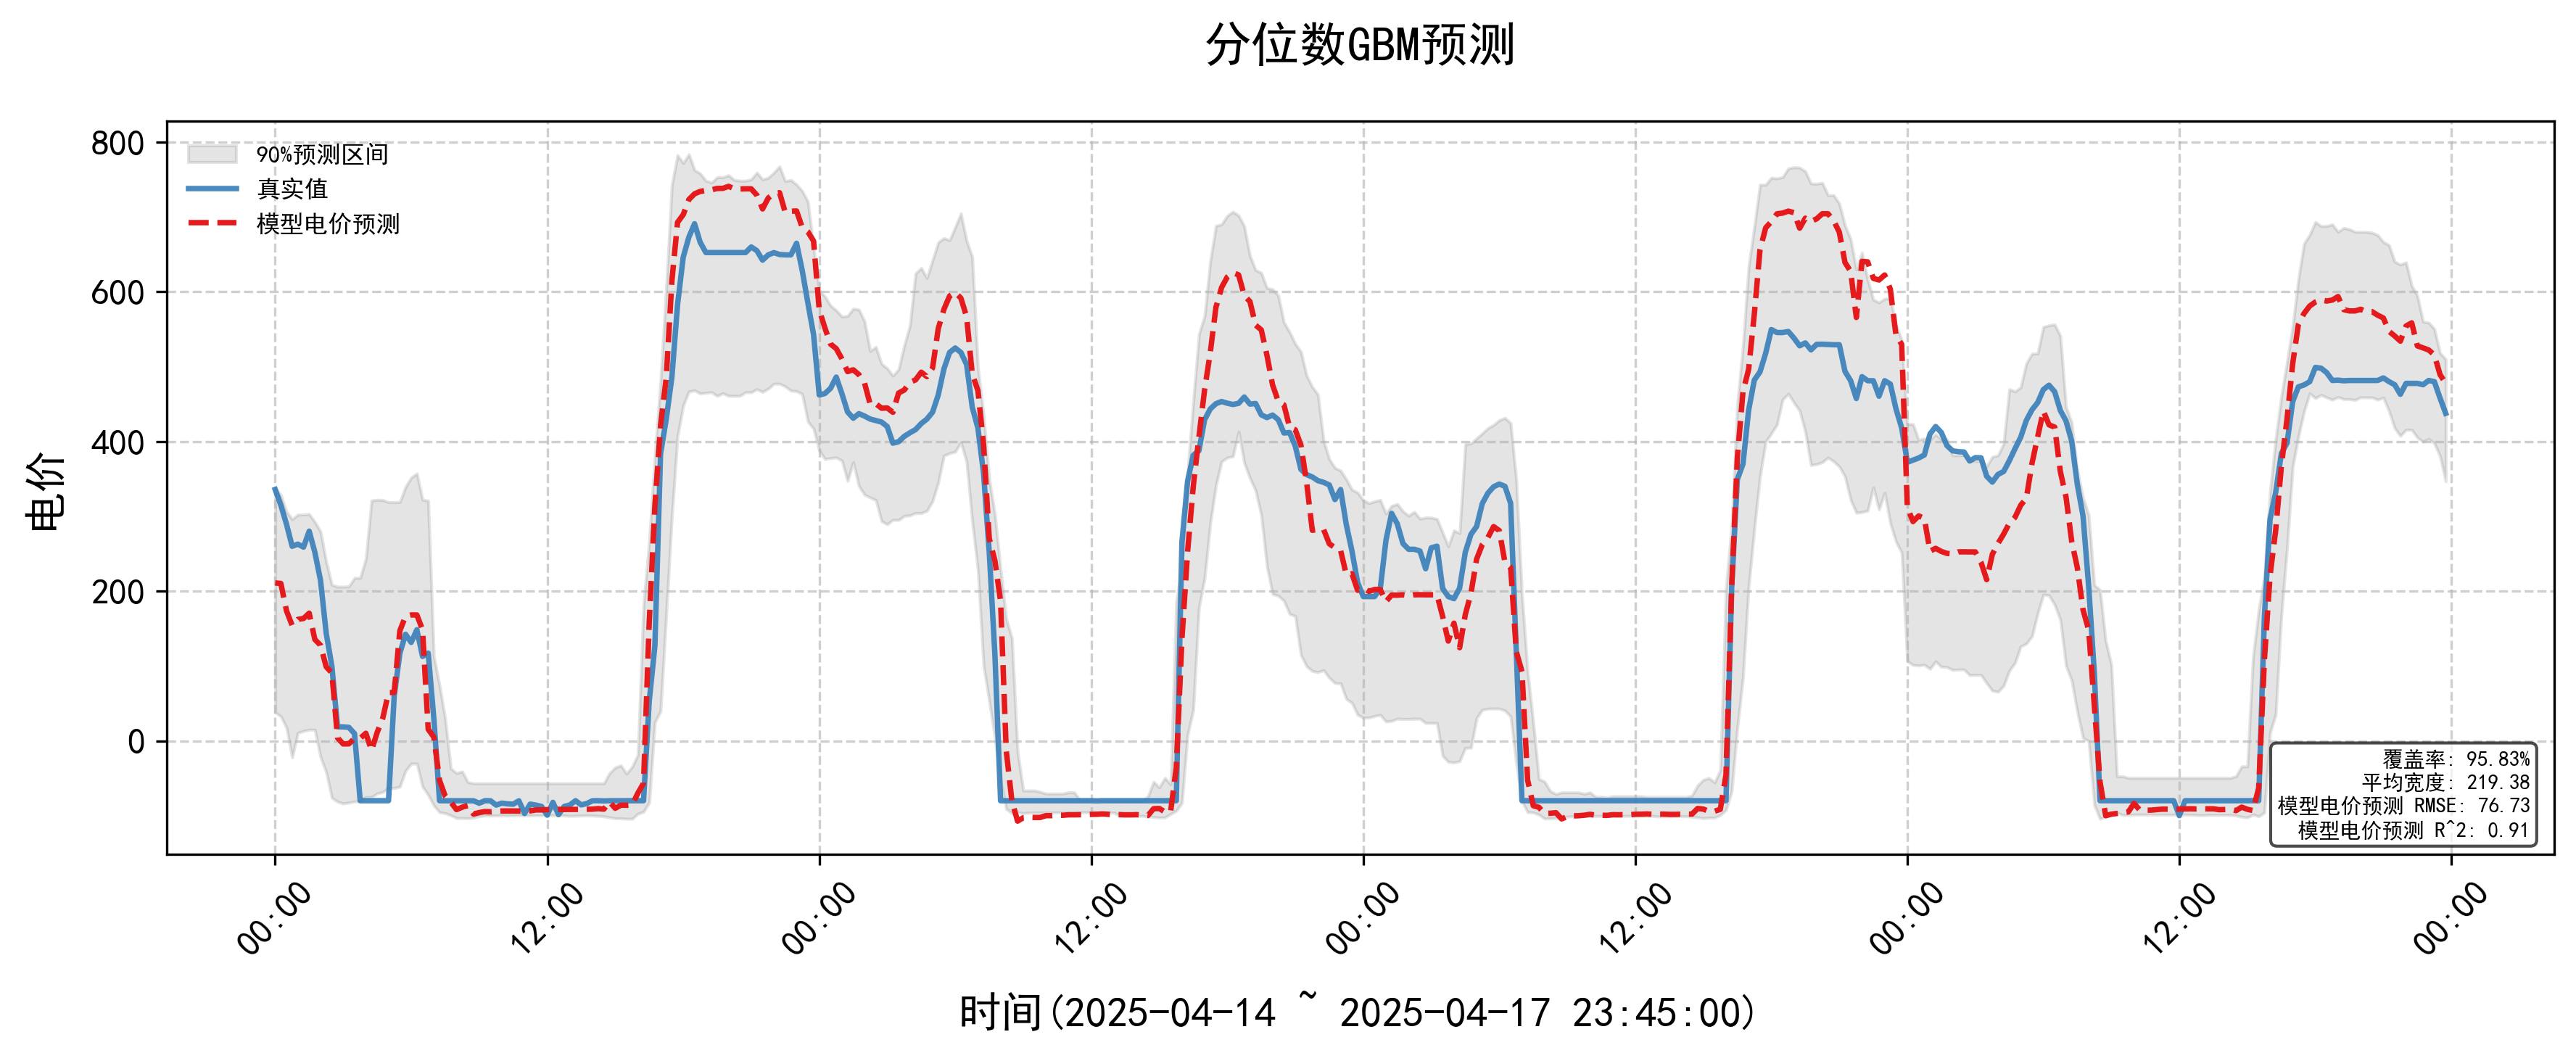

In [6]:
plot_data_gbm = pd.DataFrame()
# 真实值
plot_data_gbm["真实值"] = y_test.values
# 预测区间
plot_data_gbm["低分位数预测"] = pred_lower
plot_data_gbm["高分位数预测"] = pred_upper
# 预测值
plot_data_gbm["模型电价预测"] = pred_median
plot_data_gbm["线上日前预测"] = test_data['线上日前电价预测'].values
# plot_data_gbm的索引为测试集的日期
plot_data_gbm.index = test_data.index
# plot_prediction_intervals(plot_data_gbm,columns_must=["真实值","低分位数预测","高分位数预测"],columns_optional=["模型电价预测","线上日前预测"],title = '分位数GBM预测',st='2025-04-14',interval_num=90)
plot_prediction_intervals(plot_data_gbm,columns_must=["真实值","低分位数预测","高分位数预测"],columns_optional=["模型电价预测"],title = '分位数GBM预测',st='2025-04-14',interval_num=90)

In [18]:
# 评估
metrics_orig = evaluate_intervals(y_test, pred_lower, pred_upper, pred_median)

print("初始分位数GBM模型评估指标：")
for metric, value in  list(metrics_orig.items())[:-2]:
    print(f"{metric}: {value:.4f}")

初始分位数GBM模型评估指标：
RMSE: 83.8784
MAE: 59.8268
R2: 0.8614
Coverage: 0.8211
Mean Width: 210.1575
Winkler Score: 381.1044
Overshoot_combined_score: 93.6074
Overshoot_total_penalties: 83591.4455
Overshoot_total_amount: 23232.4835


### 评估不同的百分比区间的模型

In [8]:
compare_different_quantile_model(X_train, y_train,X_test,y_test,quantiles_list=[[0.05, 0.95],[0.10,0.90],[0.15,0.85]])

,覆盖率,平均宽度,综合分数Winkler_Score,越界Combine_Score,越界总惩罚,越界总幅度
model_90,0.821114,210.157545,381.104446,93.607442,83591.445534,23232.483532
model_80,0.566907,142.609504,617.912417,109.090717,235854.129602,65327.076801
model_70,0.488582,112.208113,734.705431,126.101869,321938.072631,88086.918291


## 加入验证集进行区间校准

In [9]:
# # 划分数据集
train_data_2, val_data_2, test_data_2 = split_data(df,train_ratio=0.7, val_ratio=0.1)

# 训练集、验证集和测试集的特征和标签
X_train_2 = train_data_2[features]
y_train_2 = train_data_2['日前电价']
X_val_2 = val_data_2[features]
y_val_2 = val_data_2['日前电价']
X_test_2 = test_data_2[features]
y_test_2 = test_data_2['日前电价']
print(f"训练集大小: {X_train_2.shape}")
print(f"验证集大小: {X_val_2.shape}")
print(f"测试集大小: {X_test_2.shape}")


训练集大小: (17472, 18)
验证集大小: (2496, 18)
测试集大小: (4992, 18)


In [10]:
# 训练分位数模型
model_lower_2, model_upper_2, model_median_2 = quantile_gbm_train(X_train_2, y_train_2,quantiles=(0.10, 0.90))
# 2. 生成预测
pred_lower_2, pred_upper_2 , pred_median_2 = predict_interval((model_lower_2, model_upper_2,model_median_2), X_test_2)
# 3. 用验证集计算校准量
# 获取验证集初始区间
val_lower = model_lower_2.predict(X_val_2)  # 5%分位数模型
val_upper = model_upper_2.predict(X_val_2)  # 95%分位数模型

# 分别计算下界和上界误差
error_lower = np.maximum(val_lower - y_val_2, 0)
error_upper = np.maximum(y_val_2 - val_upper, 0)

q_lower = np.percentile(error_lower, 90)  # 使用85%分位数作为校准量
q_upper = np.percentile(error_upper, 90)
print(f"非对称校准量：下界 {q_lower:.3f} | 上界 {q_upper:.3f}")
#非对称校准
calibrated_lower = pred_lower_2 - q_lower
calibrated_upper = pred_upper_2 + q_upper

非对称校准量：下界 23.975 | 上界 14.217


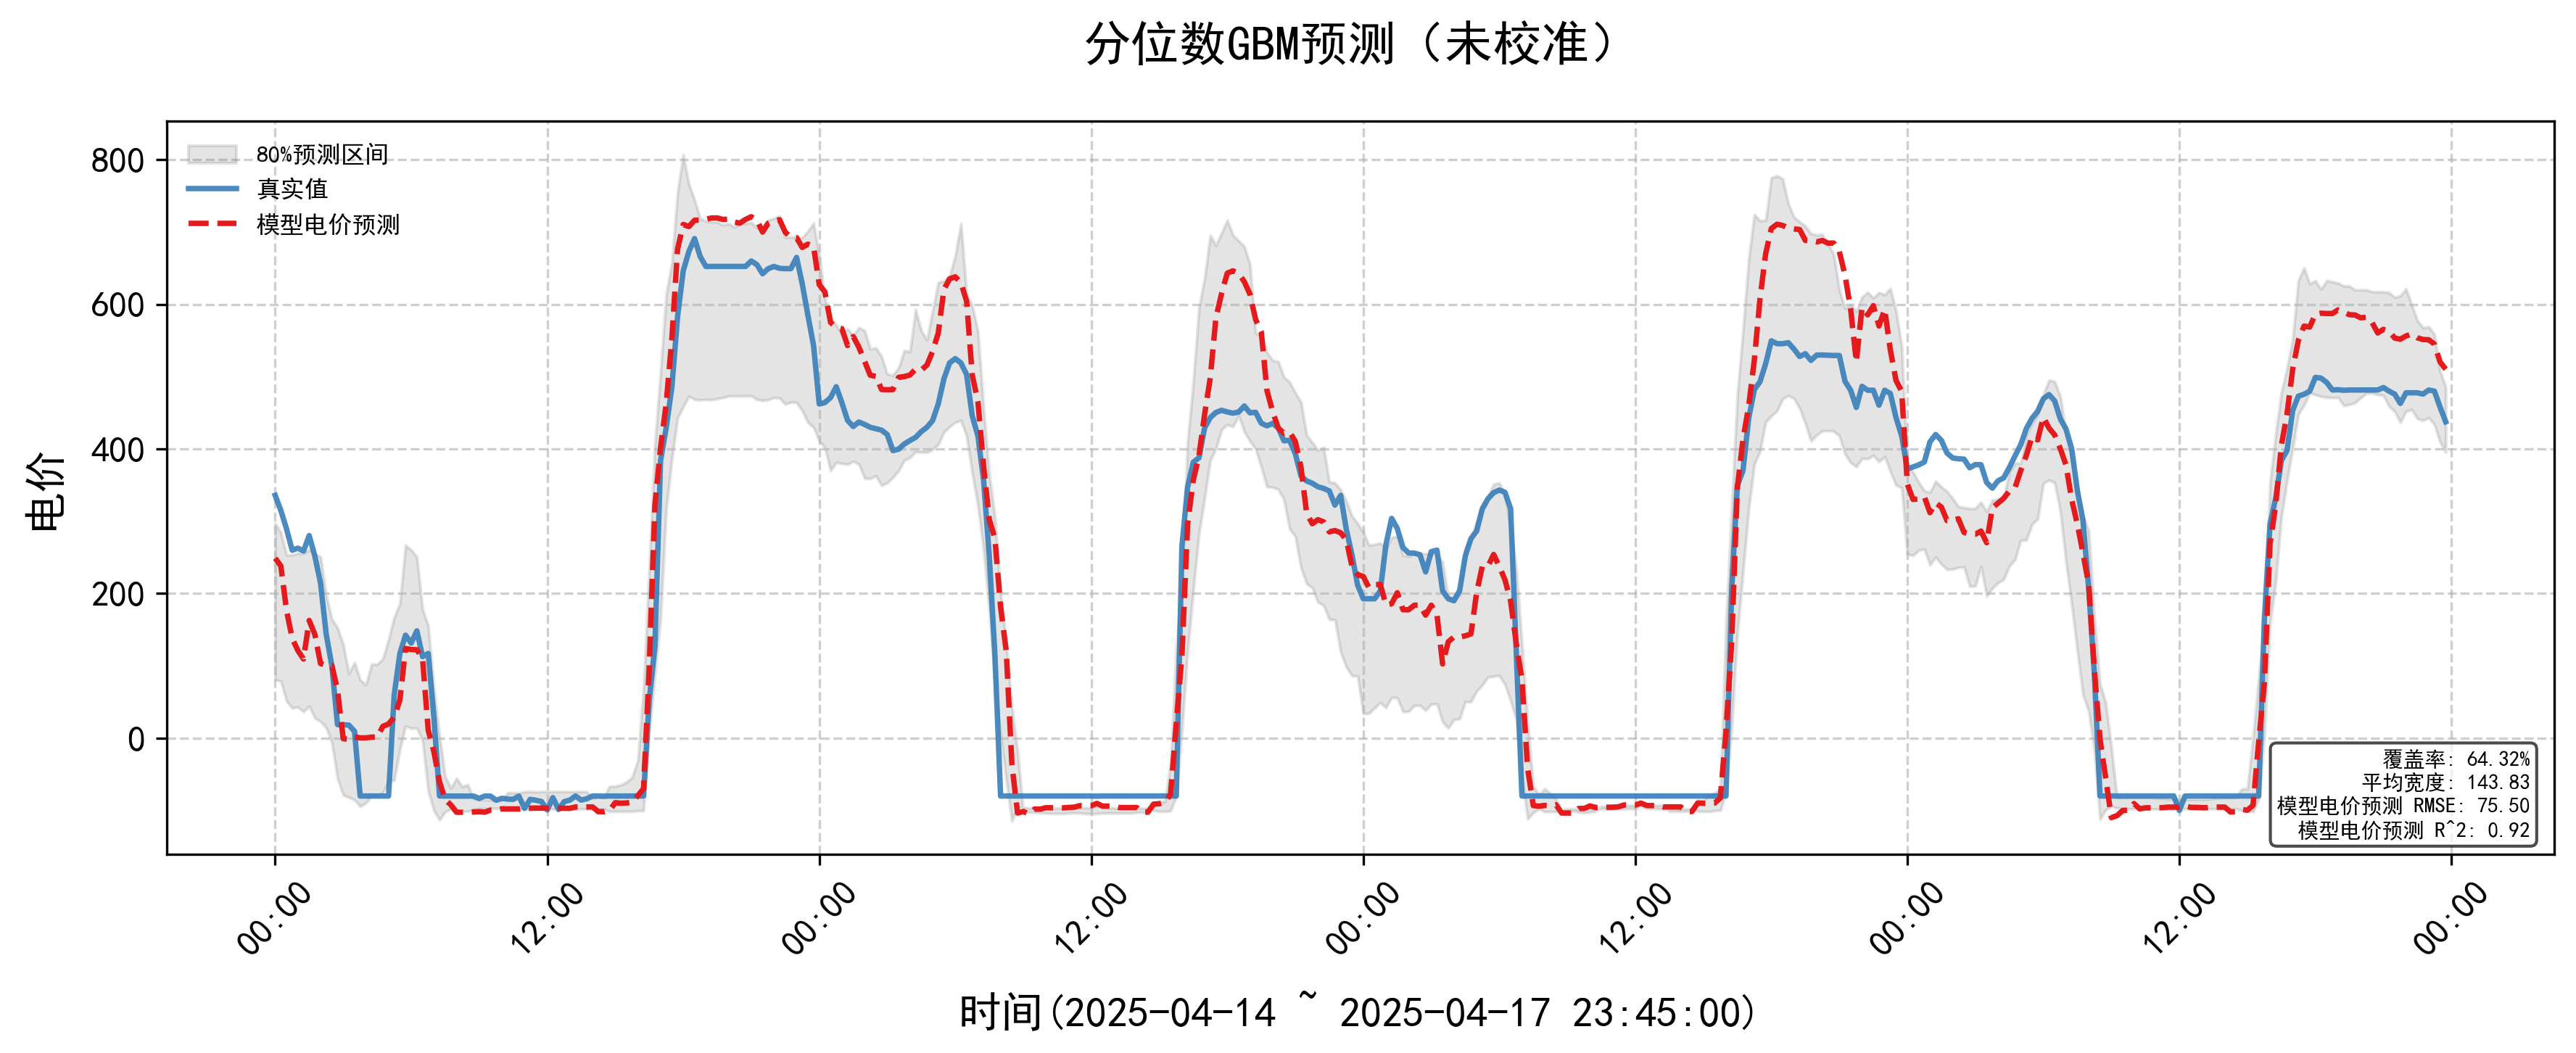

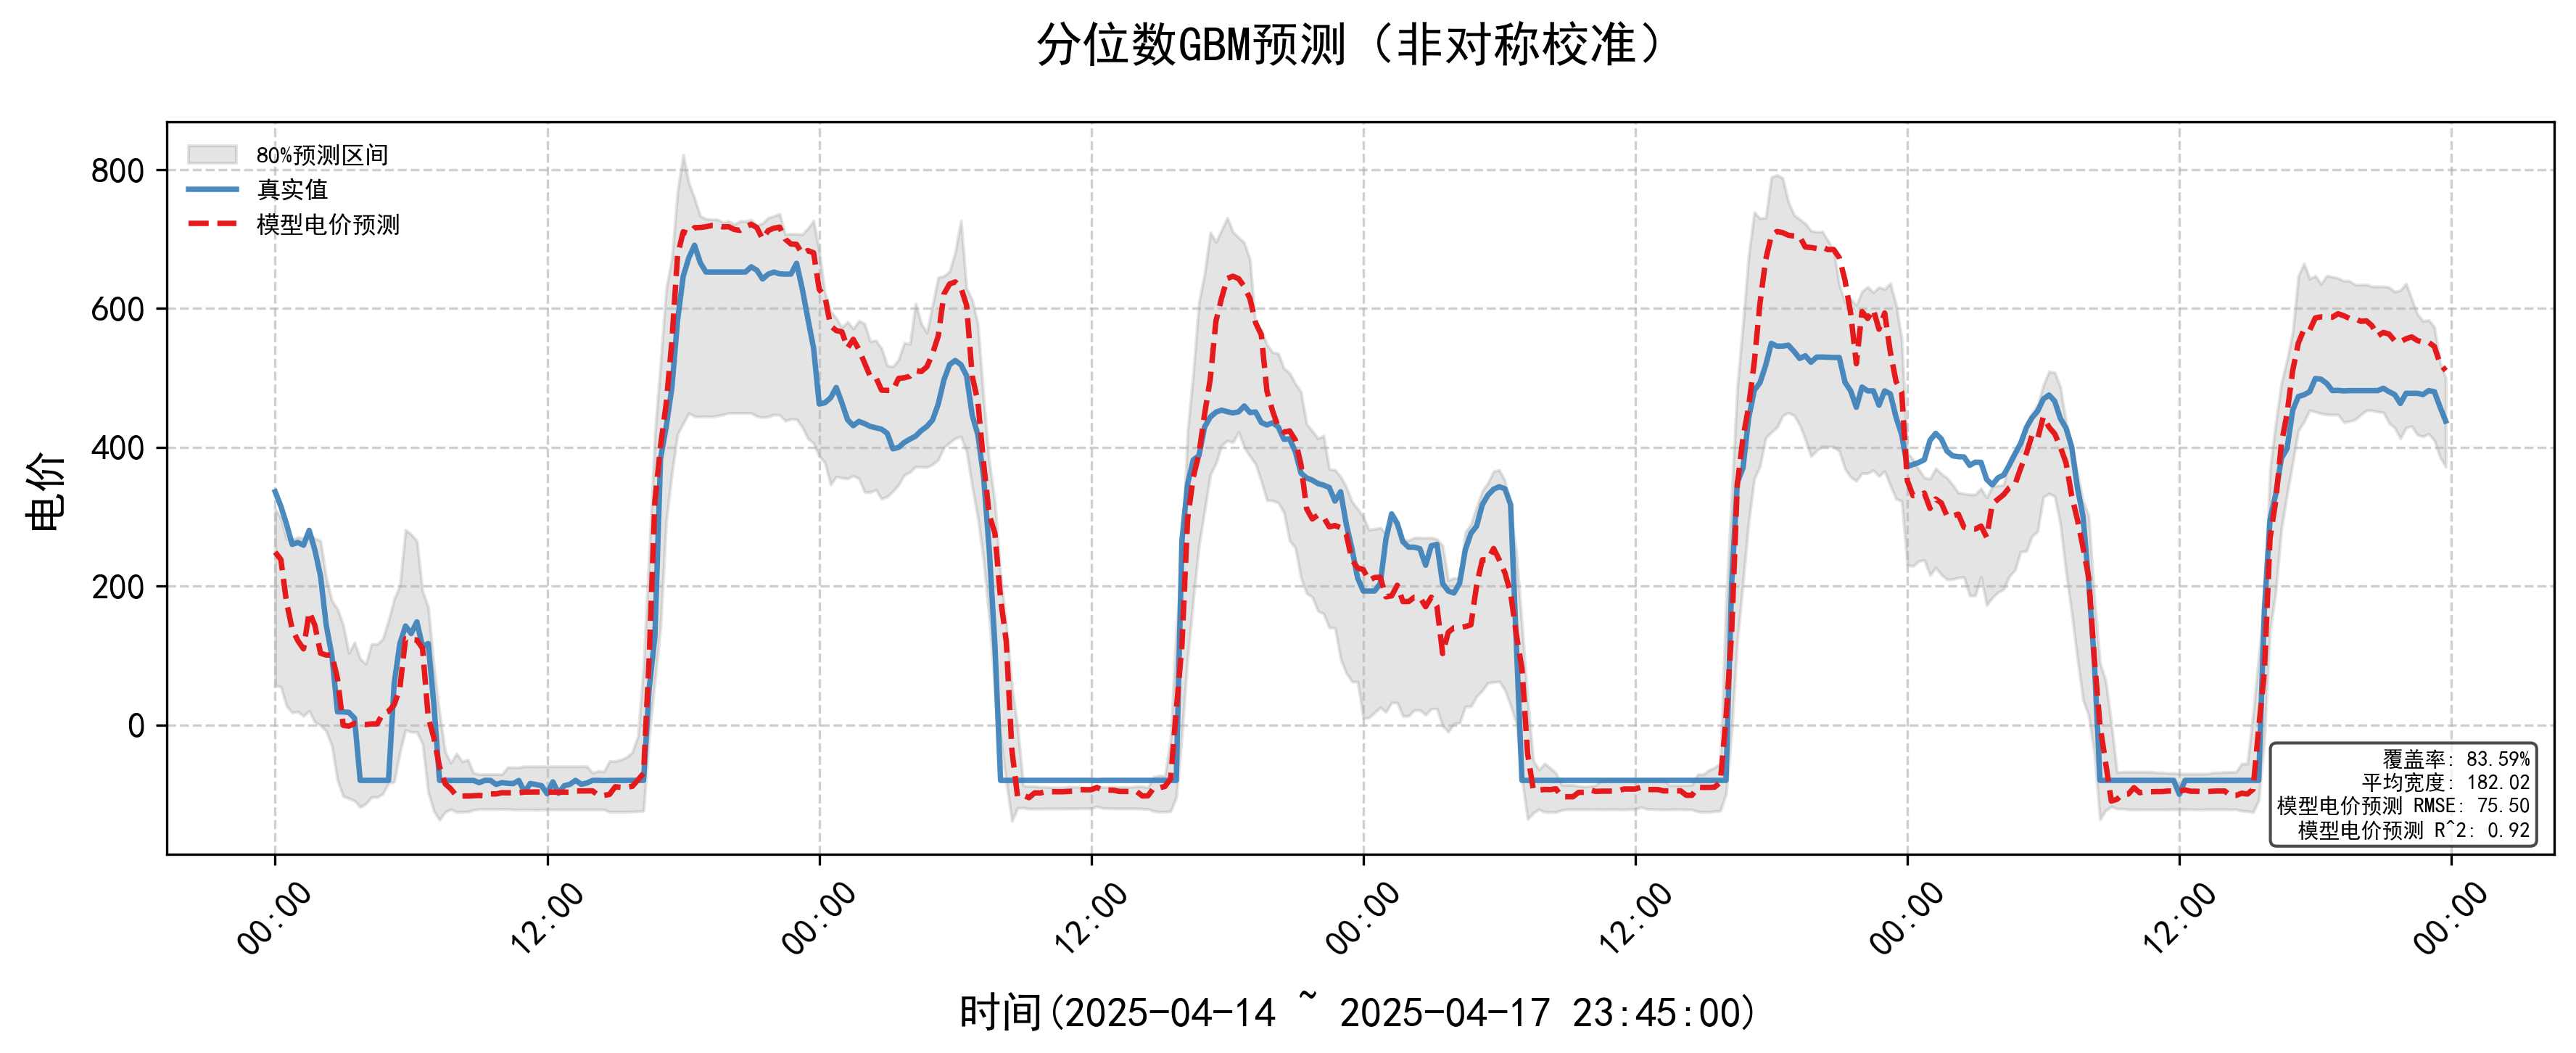

In [11]:
# 可视化结果（未校准）
plot_data_uncalibrated = pd.DataFrame()
# 真实值
plot_data_uncalibrated["真实值"] = y_test_2.values
# 预测区间
plot_data_uncalibrated["低分位数预测"] = pred_lower_2
plot_data_uncalibrated["高分位数预测"] = pred_upper_2
# 预测值
plot_data_uncalibrated["模型电价预测"] = pred_median_2
# plot_data_uncalibrated的索引为测试集的日期
plot_data_uncalibrated.index = test_data_2.index
plot_prediction_intervals(plot_data_uncalibrated,columns_must=["真实值","低分位数预测","高分位数预测"],columns_optional=["模型电价预测"],title = '分位数GBM预测（未校准）',st='2025-04-14',interval_num=80)


# 可视化结果（非对称校准）
plot_data_calibrated = pd.DataFrame()
# 真实值
plot_data_calibrated["真实值"] = y_test_2.values
# 预测区间
plot_data_calibrated["低分位数预测_calibrated"] = calibrated_lower
plot_data_calibrated["高分位数预测_calibrated"] = calibrated_upper
# 预测值
plot_data_calibrated["模型电价预测"] = pred_median_2
# plot_data_calibrated的索引为测试集的日期
plot_data_calibrated.index = test_data_2.index
plot_prediction_intervals(plot_data_calibrated,columns_must=["真实值","低分位数预测_calibrated","高分位数预测_calibrated"],columns_optional=["模型电价预测"],title = '分位数GBM预测（非对称校准）',st='2025-04-14',interval_num=80)


### 评估指标

In [13]:
result_concat = plot_data_uncalibrated.merge(
    plot_data_calibrated,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes=('', '_calibrated')  # 自动处理重复列名
)
evaluate_compare_df(result_concat,label_name="真实值",columns_of_models=[['低分位数预测','高分位数预测','QR-GBM-90-未校准'],['低分位数预测_calibrated','高分位数预测_calibrated','QR-GBM-90-非对称校准']])

,覆盖率,平均宽度,综合分数Winkler_Score,越界Combine_Score,越界总惩罚,越界总幅度
QR-GBM-90-未校准,0.624599,146.495013,567.775201,109.404122,205132.728978,57698.242470
QR-GBM-90-非对称校准,0.786859,184.687240,452.721854,116.851360,124329.846768,35357.249893


## 绘制散点图

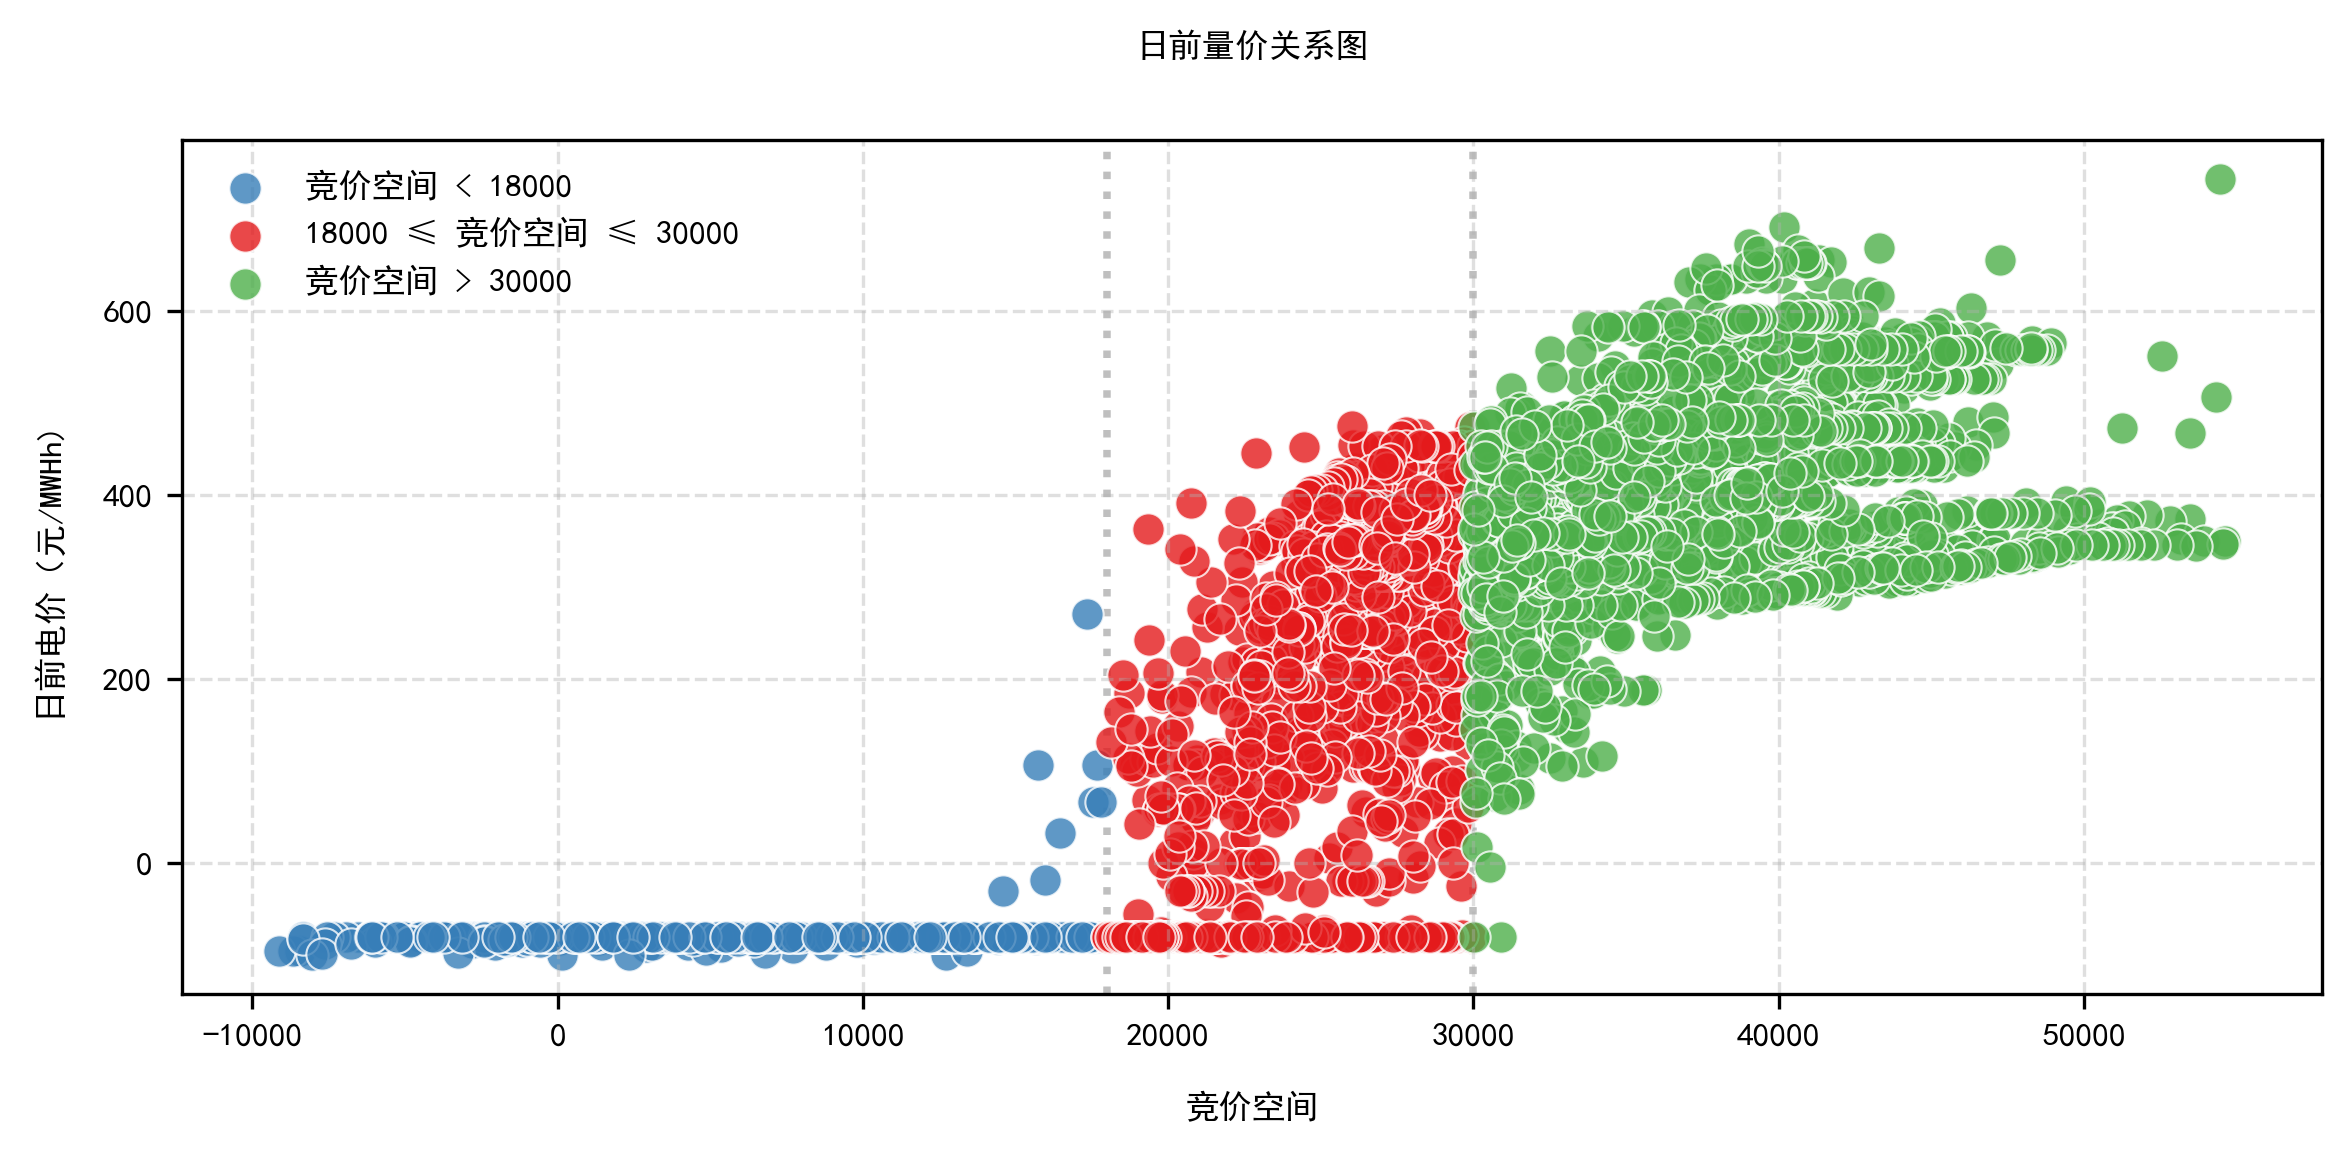

In [17]:
x = test_data["竞价空间"].values
y = test_data["日前电价"].values

plot_grouped_scatter(
    x_data=x,
    y_data=y,
    x_bounds=(18000, 30000),  # 分界点x1=40, x2=60
    colors=('#377eb8', '#e41a1c', '#4daf4a'),  # 蓝-红-绿
    x_label="竞价空间",
    y_label="日前电价（元/MWHh)",
    title="日前量价关系图",
    figsize=(8,4),
    fontsize=8
)